## Dependencies
All modules and packages required for the project.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from util.ImageGeneration import *
from util.helper_functions import *

from collections import deque

## Task 2

In [2]:
# Softmax Regression - Task 2
class SoftmaxRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization, seed):
        random.seed(seed)
        
        self.n = len(X_train)                                           # of training examples
        self.d = len(X_train[0])                                        # of features
        self.labels = 4                                                 # of classes (colors)
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]         # Training data
        self.X_test = X_test                                            # Testing data
        self.X_val = X_val                                              # Validation data
        self.y_train = y_train                                          # Training classification Labels
        self.y_test = y_test                                            # Testing classification Labels
        self.y_val = y_val                                              # Validation classification Labels
        self.weights = np.zeros((self.labels, self.d))                  # Current parameters / weights with d rows
        self.lr = lr                                                    # Learning rate   
        self.epsilon = epsilon                                          # Early stopping difference
        self.regularization, self.Lambda, self.decay = regularization   # Type of regularization, penalty, and decay of the penalty

    # Helper methods 
    # dataset = 0 - train; 1 - val; 2 - test
    def dataset_picker(self, dataset = 0):
        if dataset == 0:
            return self.X_train, self.y_train
        elif dataset == 1:
            return self.X_test, self.y_test
        else:
            return self.X_val, self.y_val

    # Helper methods 
    def predict(self, inds=None, dataset = 0):
        """Compute h_w(x_i) for the provided weight values"""
        X, y = self.dataset_picker(dataset)
        if inds is None:
            inds = np.arange(len(X))

        # pred = []
        # for label in range(self.labels):
        #     dot_product = np.dot(X[inds], self.weights[label].T)
        #     pred.append(softmax(dot_product))

        # return np.array(pred)
        
        dot_product = np.dot(self.weights, X[inds].T)
        return softmax(dot_product)

    def loss(self, Y, P):
        """Compute the current value of average loss based on predictions"""
        buffer = 1e-15
        #print(Y.shape, P.shape)
        loss = np.mean(-Y.T * np.log(P + buffer))
        if self.regularization == 2:
            loss += np.sum(self.Lambda * np.square(self.weights))
        return loss
    
    def accuracy(self, gold_labels, preds):
        #print(preds.shape)
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if np.array_equal(pred, gold) else 0 for pred, gold in zip(pred_labels.T, gold_labels)]
        count, total = sum(correct), len(correct)
        acc = round(count/total*100, 2)
        
        return acc, count, total
    
    def predict_loss_acc(self, inds=None, dataset=0):
        X, y = self.dataset_picker(dataset)
        preds = self.predict(inds, dataset)

        loss = self.loss(y, preds)
        acc, correct, total = self.accuracy(y, preds)
        
        return loss, acc
    
    def gd(self):
        """Run a single epoch of GD"""
        pass
    
    def sgd(self):
        """Run a single epoch of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            resid = self.y_train[ind] - self.predict(ind)
            resid = resid[:, np.newaxis]
            x_col = self.X_train[ind][:, np.newaxis].T
            # print(resid.shape, x_col.shape, self.weights.shape)
            gradient = -1 * np.matmul(resid, x_col)
            
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient

    # Stochastic Gradient Descent
    def train(self, epochs, display_steps = 1, stochastic=True):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        print("Epoch\t\tTrainLoss\tValLoss\t\tTrainAcc\tValAcc")  
        for epoch in range(epochs):
            if stochastic:
                self.sgd()
            else: self.gd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=2)
            
            self.train_losses.append(loss_train)
            self.val_losses.append(loss_val)
            self.train_accuracies.append(acc_train)
            self.val_accuracies.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % display_steps == 0:
                print(f"{epoch}\t\t{round(loss_train, 3)}\t\t{round(loss_val, 3)}\t\t{acc_train}%\t\t{acc_val}%")
                #print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                #print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 10:
                prev_loss.popleft()
            if len(prev_acc) > 10:
                prev_acc.popleft()

            self.Lambda *= self.decay
                
    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        max_ind = np.argmax(pred)
        one_hot = np.zeros_like(pred)
        one_hot[max_ind] = 1
        return one_hot
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(preds.shape[1]):
            #print(preds[:,i].shape, preds[:,i])
            preds[:,i] = self.indicator(preds[:,i])
            
        return preds

    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = self.predict(dataset=0)
        acc_train, correct_train, total_train = self.accuracy(self.y_train, probs_train)
        print(f"TRAINING ACCURACY: {acc_train}%, {correct_train}/{total_train}")
        
        probs_test = self.predict(dataset=1)
        acc_test, correct_test, total_test = self.accuracy(self.y_test, probs_test)
        print(f"TESTING ACCURACY: {acc_test}%, {correct_test}/{total_test}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.val_losses, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.train_accuracies, "Train"), (self.val_accuracies, "Validation")])


In [19]:
# Generate and Preprocess Data
data = DataSet()
SEED = 718067190
img_gen = ImageGenerator(1000, dataset = data, seed = SEED, task = 2)
image_data, _, third_wires = preprocess_data(data, "convolution")
image_data.shape

(1000, 2249)

In [20]:
# Set hyperparameters and train Model
lr = .01
epsilon = .0005
Lambda, decay = .01, .6
EPOCH_LIM = 500
regularization = (2, Lambda, decay)
ttv_split = train_test_validation_split(image_data, third_wires) # train, test, and validation

softm = SoftmaxRegression(*ttv_split, lr, epsilon, regularization, seed = SEED)
sgd = softm.train(EPOCH_LIM)
predictions = softm.get_pred_labels(softm.predict())

Epoch		TrainLoss	ValLoss		TrainAcc	ValAcc
0		0.943		1.123		36.5%		25.0%
1		0.783		1.128		41.12%		27.0%
2		0.956		1.384		37.62%		29.0%
3		0.736		1.142		44.88%		23.0%
4		0.653		1.152		45.25%		22.0%
5		0.567		1.108		50.12%		30.0%
6		0.522		1.094		50.38%		25.0%
7		0.527		1.237		51.75%		22.0%
8		0.712		1.527		45.5%		14.0%
9		0.511		1.286		51.38%		22.0%
10		0.47		1.173		56.0%		29.0%
11		0.44		1.217		58.5%		23.0%
12		0.502		1.419		54.37%		24.0%
13		0.46		1.073		58.63%		31.0%
14		0.392		1.08		58.0%		29.0%
15		0.459		1.12		60.62%		32.0%
16		0.415		1.244		58.63%		28.0%
17		0.389		1.309		63.25%		26.0%
18		0.379		1.081		61.75%		29.0%
19		0.352		1.335		63.5%		22.0%
20		0.332		1.099		67.25%		34.0%
21		0.319		1.055		64.62%		34.0%
22		0.258		1.257		70.62%		21.0%
23		0.362		1.24		63.0%		31.0%
24		0.267		1.125		68.88%		25.0%
25		0.266		1.13		69.25%		22.0%
26		0.249		1.257		71.25%		24.0%
27		0.25		1.204		66.62%		22.0%
28		0.249		1.416		69.75%		22.0%
29		0.254		1.329		70.0%		32.0%
30		0.214		1.12		72.25%	

TRAINING ACCURACY: 99.88%, 799/800
TESTING ACCURACY: 35.0%, 35/100


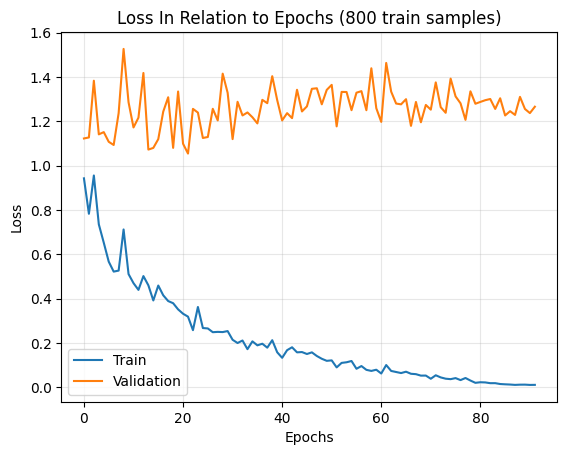

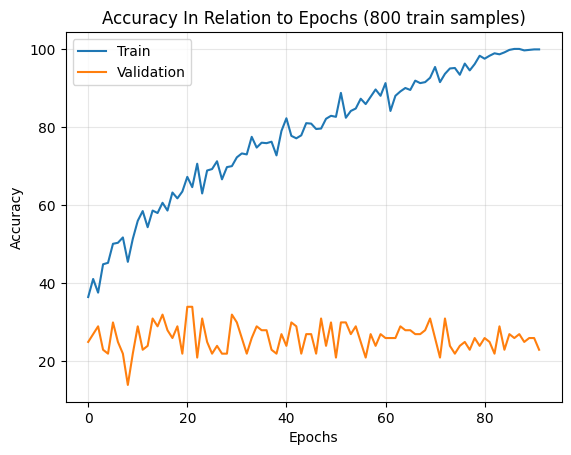

SUM OF WEIGHTS: 2128.8405309198893
(4, 2249)


In [23]:
softm.test()
print(f"SUM OF WEIGHTS: {np.sum(abs(softm.weights))}")
print(softm.weights.shape)

In [12]:
pred = softm.predict()
pred

array([[0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, ..., 0.25, 0.25, 0.25]])